<h1><center>Linear Regression on Kaggle Competition for House Prices</center></h1>

Data from [Kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/overview)


Clase: https://www.youtube.com/watch?v=OTg6BzBQNGI&ab_channel=Dr.ArrigoCoen


In [87]:
# Import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.linear_model import LinearRegression 
from sklearn import metrics

# to add plots to your Jupyter notebook we use the next command
# %matplotlib inline 
pd.set_option('display.max_rows', 90) # by default is 10, if change to None print ALL
pd.set_option('display.max_columns', 90) # by default is 10, if change to None print ALL

Import Data
---

**Es importante que modifiquen la variable ```team_members``` con respecto a los miembros del equipo que tengan.**

In [7]:
# read the data into a pandas dataFrame
df = pd.read_csv('OneDrive/Documentos/SEMESTRE 2021-2/Ciencia de Datos Seminario/Regresión/Housesdata.csv')

# El siguiente diccionario contiene los nombres y números de cuenta de cada miempbro del equipo
team_members = {"David Montaño Castro": 316200132} 
if len(team_members)>3:
    print("El máximo número de miembros de un equipo es tres, favor de corregirlo.")

# Fixing the seeds
np.random.seed(sum(team_members.values()))
random.seed(sum(team_members.values()))

columns_to_work_with = random.choices(list(df.columns[1:80]),k=5)

df = df[columns_to_work_with + ['SalePrice']]

In [14]:
df.head()

,Electrical,BldgType,Fence,PavedDrive,LotConfig,SalePrice
0,SBrkr,1Fam,NaN,Y,Inside,208500
1,SBrkr,1Fam,NaN,Y,FR2,181500
2,SBrkr,1Fam,NaN,Y,Inside,223500
3,SBrkr,1Fam,NaN,Y,Corner,140000
4,SBrkr,1Fam,NaN,Y,FR2,250000


Análisis Exploratorio de los Datos
---

### Dimensiones del DataFrame

In [15]:
df.shape

(1460, 6)

### Explicación y descripción de las variables

Podemos ver que tenemos las siguientes variables:
1. Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed
    
2. BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit
      
3. Fence: Fence quality
		
       GdPrv	Good Privacy
       MnPrv	Minimum Privacy
       GdWo	Good Wood
       MnWw	Minimum Wood/Wire
       NA	No Fence
       
4. PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel
   
5. LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property
 
 Ahora veamos de que tipos son y si tienen valores nulos

### Tipos de variables por columna

In [17]:
df.dtypes

Electrical    object
BldgType      object
Fence         object
PavedDrive    object
LotConfig     object
SalePrice      int64
dtype: object

### ¿Existen valores nulos o vacios?

Para empezar, es necesario notar que las 5 variables que se tienen para la regresión son categóricas, de las cuales __Fence__ es ordinal y contiene 1179 NaN valores; sin embargo, es importante notar que aunque sí, en cierto sentido __Fence__ contiene dos valores que podrían llegar a ser considerados ordinales (GdPev > MnPrv), los siguentes registros no guardan algún orden entre ellos mismos. Por tanto, he optado por considerar este campo como una variables categórica nominal, esto es, no existe orden y el número que represente cada registro será simple notación.  Así mismo, __Electrical__ contiene un valor NaN. Por medio de una análisis visual determinaré por cuáles valores es más apropiado reemplazarlos. 

In [31]:
df.Fence.value_counts()

MnPrv    157
GdPrv     59
GdWo      54
MnWw      11
Name: Fence, dtype: int64

In [18]:
df.isna().sum()

Electrical       1
BldgType         0
Fence         1179
PavedDrive       0
LotConfig        0
SalePrice        0
dtype: int64

Visualización de los datos
---

### Electrical


Text(0, 0.5, 'Cuenta')

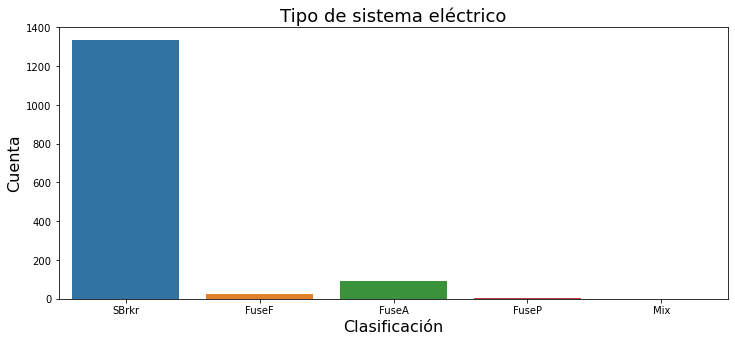

In [40]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.countplot(df.Electrical)
plt.title('Tipo de sistema eléctrico', fontsize=18)
plt.xlabel('Clasificación', fontsize=16)
plt.ylabel('Cuenta', fontsize=16)

Es claro que la moda de los datos es SBrkr. Desde que la columna corresponde a una variable categórica y además la moda es bastante clara, he decidido sustituir el valor NaN por el valor de la moda de la columna.

In [26]:
df["Electrical"] = df["Electrical"].fillna(df["Electrical"].mode()[0])

### BldgType

Text(0, 0.5, 'Cuenta')

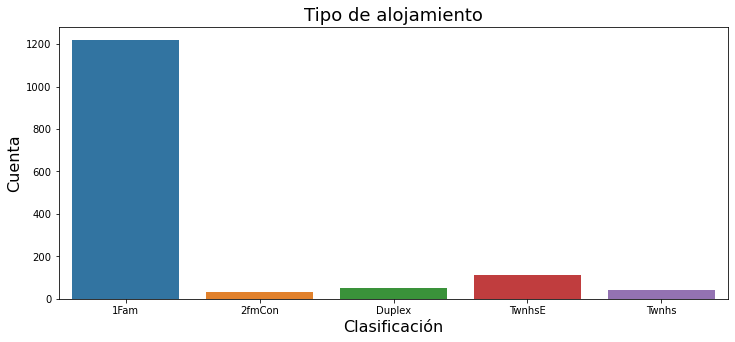

In [41]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.countplot(df.BldgType)
plt.title('Tipo de alojamiento', fontsize=18)
plt.xlabel('Clasificación', fontsize=16)
plt.ylabel('Cuenta', fontsize=16)

### Fence 

Text(0, 0.5, 'Frecuencia')

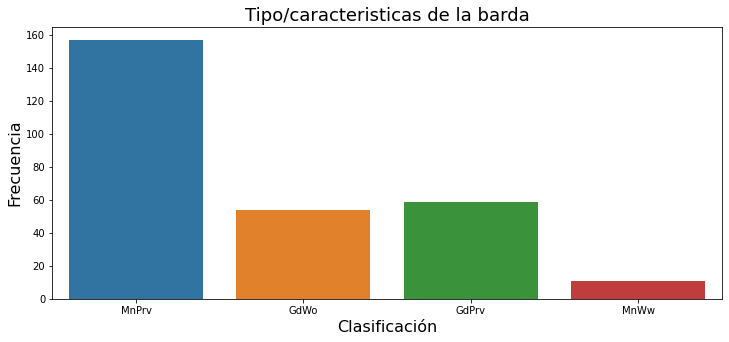

In [43]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.countplot(df.Fence)
plt.title('Tipo/caracteristicas de la barda', fontsize=18)
plt.xlabel('Clasificación', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)

Contrario a lo que se consideró en __Electrical__, los NaN valores que están presentes en esta columna no se deben al desconocimiento del valor en cuestion, sino que las personas confesaron no tener barda. Así, llegue a la decisión de sustituir con la variable "No hay" estos valores en lugar de llenarlo con alguna estadística.

In [47]:
df["Fence"].fillna("No hay",inplace = True)

In [50]:
df.isna().sum()

Electrical    0
BldgType      0
Fence         0
PavedDrive    0
LotConfig     0
SalePrice     0
dtype: int64

Text(0, 0.5, 'Frecuencia')

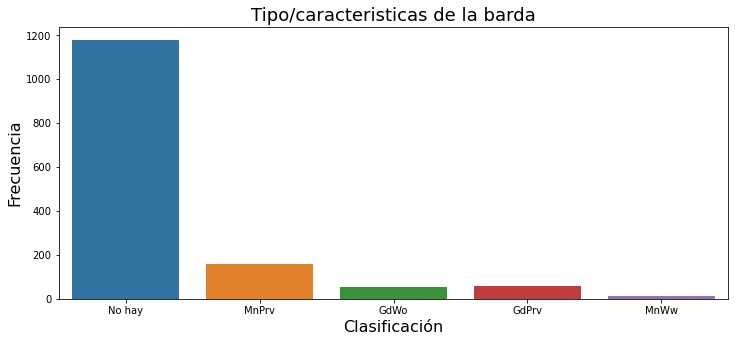

In [51]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.countplot(df.Fence)
plt.title('Tipo/caracteristicas de la barda', fontsize=18)
plt.xlabel('Clasificación', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)

### PavedDrive

Text(0, 0.5, 'Frecuencia')

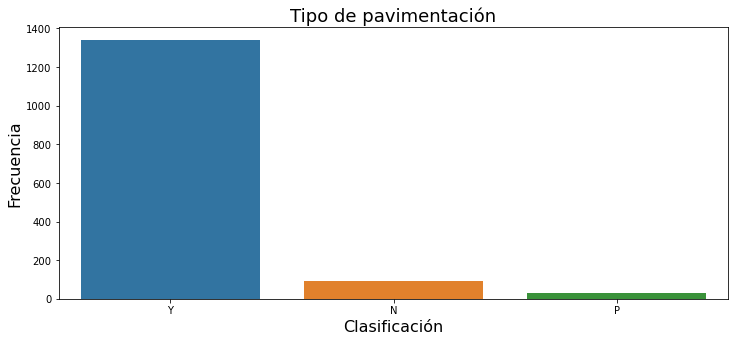

In [55]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.countplot(df.PavedDrive)
plt.title('Tipo de pavimentación', fontsize=18)
plt.xlabel('Clasificación', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)

### LotConfig  

Text(0, 0.5, 'Frecuencia')

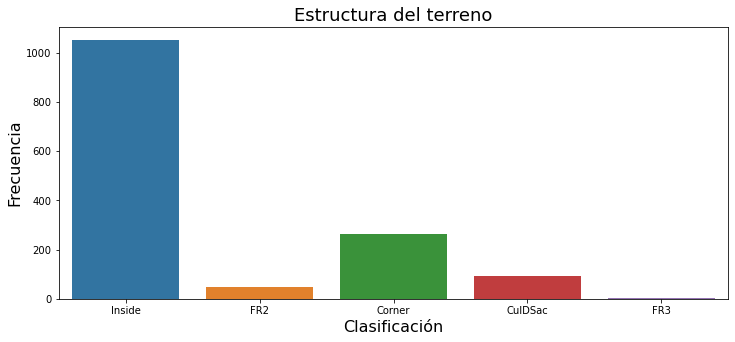

In [57]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.countplot(df.LotConfig)
plt.title('Estructura del terreno', fontsize=18)
plt.xlabel('Clasificación', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)

### SalePrice
Distribución con gran curtosis y sesgada a la derecha. Muy pocas personas puedes comprar una casa tan cara, lo cual provoca un sesgo positivo.

Text(0, 0.5, 'Frecuencia')

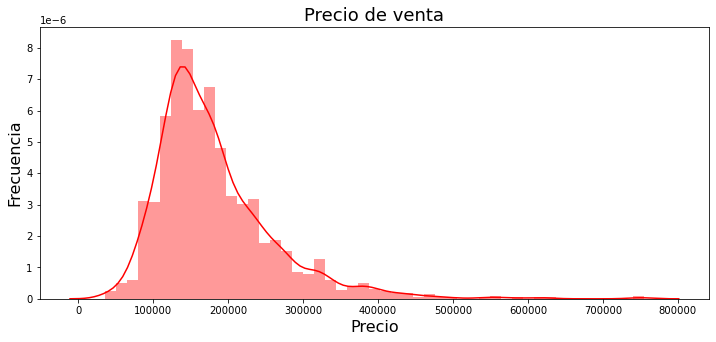

In [35]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.distplot(df.SalePrice, color = "red")
plt.title('Precio de venta', fontsize=18)
plt.xlabel('Precio', fontsize=16)
plt.ylabel('Frecuencia', fontsize=16)

Data Wrangling
---

### IMPORTATE : Observaciones
 1. Variables categóricas-ordenadas se recomienda transformar usando ```OrdinalEncoder```
 2. Variables categóricas-no-ordenadas se recomienda transformar usando ```pd.get_dummies```
 3. Una vez transformadas las observaciones a valores numéricos se recomienda utilizar ```sns.pairplot``` y ```sns.heatmap```
  

### Variables Dummies

In [64]:
dummies_Electrical = pd.get_dummies(df.Electrical, prefix = "electrical", drop_first = True)
dummies_BldgType = pd.get_dummies(df.BldgType, prefix = "Bldg_Type", drop_first = True)
dummies_Fence = pd.get_dummies(df.Fence, prefix = "Fence", drop_first = True)
dummies_PavedDrive = pd.get_dummies(df.PavedDrive, prefix = "PavedDrive", drop_first = True)
dummies_LotConfig = pd.get_dummies(df.LotConfig, prefix = "LotConfig", drop_first = True)

### DataFrame Limpio

In [66]:
final_df = pd.concat([dummies_Electrical,dummies_BldgType,dummies_Fence,dummies_PavedDrive,dummies_LotConfig,df.SalePrice],axis = 1)
final_df.head()

,electrical_FuseF,electrical_FuseP,electrical_Mix,electrical_SBrkr,Bldg_Type_2fmCon,Bldg_Type_Duplex,Bldg_Type_Twnhs,Bldg_Type_TwnhsE,Fence_GdWo,Fence_MnPrv,Fence_MnWw,Fence_No hay,PavedDrive_P,PavedDrive_Y,LotConfig_CulDSac,LotConfig_FR2,LotConfig_FR3,LotConfig_Inside,SalePrice
0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,208500
1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,181500
2,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,223500
3,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,140000
4,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,1,0,0,250000


No hay necesidad de encontrar relaciones entre variables dado que se tratan de variables categóricas. De cualquier forma, si se desea opservar el pairplot de final_df, puede descomentarse el método de abajo.

In [68]:
#sns.pairplot(final_df)

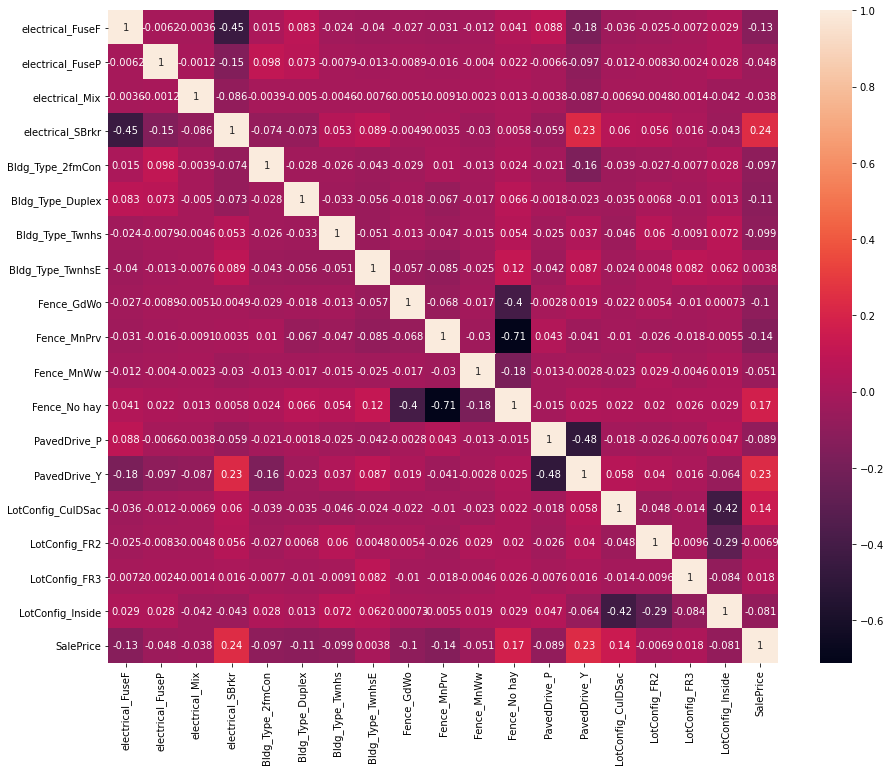

In [74]:
fig,ax = fig, ax = plt.subplots(figsize = [15,12])
sns.heatmap(final_df.corr(), annot = True)

Separar los datos entre Entrenamiento y Prueba
---

In [79]:
X = final_df.drop(columns = "SalePrice")
Y = final_df["SalePrice"]
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=sum(team_members.values())) 

Construir el modelo
---

In [80]:
lm = LinearRegression() 
lm.fit(X_train,y_train) 

LinearRegression()

### Coeficientes de la recta de regresión

In [81]:
coeff_df = pd.DataFrame(lm.coef_,X.columns,columns=['Coefficient'])
print(coeff_df)

                    Coefficient
electrical_FuseF  -5.900512e+03
electrical_FuseP   9.999652e+03
electrical_Mix    -1.091394e-11
electrical_SBrkr   5.689274e+04
Bldg_Type_2fmCon  -3.706477e+04
Bldg_Type_Duplex  -5.020950e+04
Bldg_Type_Twnhs   -6.284290e+04
Bldg_Type_TwnhsE  -2.601730e+04
Fence_GdWo        -3.918439e+04
Fence_MnPrv       -2.696609e+04
Fence_MnWw        -3.483469e+04
Fence_No hay       1.837813e+04
PavedDrive_P       6.706911e+03
PavedDrive_Y       5.374262e+04
LotConfig_CulDSac  2.544814e+04
LotConfig_FR2      3.116088e+03
LotConfig_FR3      5.416649e+04
LotConfig_Inside   4.762075e+03


Predicciones
---

In [82]:
predictions = lm.predict(X_test)  

Evaluación del modelo
---

### Valores reales vs Valores estimados

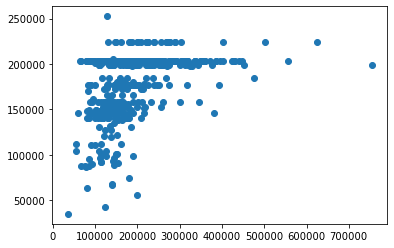

In [83]:
plt.scatter(y_test,predictions)

### Distribución de los errores

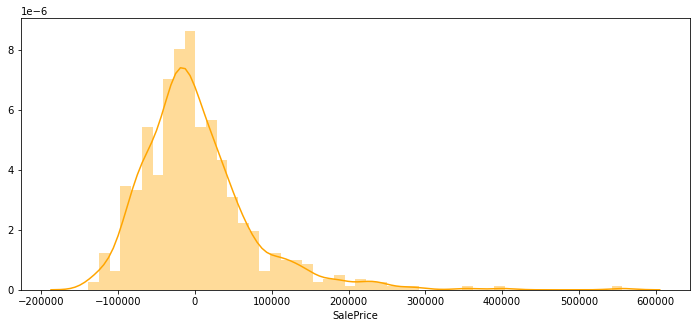

In [93]:
fig,ax = fig, ax = plt.subplots(figsize = [12,5])
sns.distplot((y_test-predictions),bins=50, color = "Orange")

### Coeficiente de determinación $R^2$

In [90]:
r2 = r2_score(y_test,predictions)

### Coeficiente de determinación $R^2$ ajustado 

In [95]:
n = len(y_train)
p = X_train.shape[1]
r_cuad_aj = 1 - (((1-r2)*(n-1))/(n-p-1))

### Otras métricas

In [96]:
print("R2:", round(r2,4))
print("R2 ajustado:", round(r_cuad_aj,4))
print('MAE:', metrics.mean_absolute_error(y_test, predictions)) 
print('MSE:', metrics.mean_squared_error(y_test, predictions)) 
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions))) 

R2: 0.1381
R2 ajustado: 0.1199
MAE: 52318.74772962059
MSE: 5623363155.712475
RMSE: 74989.08691077972


In [1]:
true_value = y_test
predicted_value = predictions

plt.figure(figsize=(10,10))
plt.scatter(true_value, predicted_value, c='crimson')

p1 = max(max(predicted_value), max(true_value))
p2 = min(min(predicted_value), min(true_value))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

NameError: name 'y_test' is not defined

Conclusión
---

Según el valor del coeficiente de determinación ajustado, el modelo describe el 10% de la varianza de la variable dependiente con respecto a la independiente, siendo esto una señal de un muy bajo rendimiento por parte de la regresión lineal simple. Es así que se concluye que no existe razón suficiente para emplear la Regresión Lineal como modelo para tratar de entender y predecir nuevos datos con este set de 5 características. 